# AK-MCS example
This notebook shows an example of applying AK-MCS (Adaptive learning method combing Kriging and Monte Carlo Sampling) on our reliability problem. The entire algorithm is based on the basic Kriging method, so we mostly follow the Kriging example in previous notebook.

Author: Haochen Ye (hxy46@psu.edu)

References: 
1. R.B. Gramacy. Surrogates: Gaussian process modeling, design and optimization for the applied sciences (2020). Chapman Hall/CRC, Boca Raton, FL. (https://bookdown.org/rbg/surrogates/)

2. Echard B, Gayton N, Lemaire M. AK-MCS: An active learning reliability method combining Kriging and Monte Carlo Simulation. Struct Saf. 2011;33: 145–154. doi:10.1016/j.strusafe.2011.01.002

3. Lelièvre N, Beaurepaire P, Mattrand C, Gayton N. AK-MCSi: A Kriging-based method to deal with small failure probabilities and time-consuming models. Struct Saf. 2018;73: 1–11. doi:10.1016/j.strusafe.2018.01.002

In [1]:
# remove all existing variables and plots
rm(list = ls())
graphics.off()
# load the required libraries
library(plgp)
library(mvtnorm)  # Multivariate normal distribution library
library(lhs) #Generate Latin Hypercube samples
library(fields) # Make grid plots
# Adding a very small number to aviod ill-conditioned matrix calculation that may happen 
#   for square matrix sometimes. (Neal, 1998)
eps <- sqrt(.Machine$double.eps)
# Problem definition
# Note in this example we modify the output as continuous, success is positive, fail is negative
#   limit state is zero. This is a requirement of AK-MCS algorithm.
Reliability<-function (X) {
  0.75-X[ ,1]*X[ ,2]
}

Loading required package: mvtnorm

Loading required package: tgp

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following object is masked from 'package:mvtnorm':

    rmvnorm


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



The code above defines the problem. Note we modify the problem output to be continuous and contain both positive and negative values as required by the algorithm. Otherwise we cannot learn anything if most responses are the same 0 or 1.

Then we adopt the Kriging example.
We begin with a very small sample size so that we can use adaptive learning to select the next sample to improve the emulator. Following Echard et al (2011), we first sample random inputs by Latin Hypercube Sampling method with a size N. Then we use the small initial size to train the Kriging model. The recommended size is (n+1)(n+2)/2 = 6 for our example n=2. However, we find that 6 initial samples already train a relative good Kriging emulator so we begin with 3 (This reflects how effective is Kriging). 

In [2]:
# Kriging part: 
# Choose a small subsample from a larger sample and fit a Kriging model to the rest samples
N <- 15000
n <- 3
n_init <- n
X_all <- data.frame(randomLHS(N,2))
# x is the samples we use, X is the rest samples
x <- X_all[c(1:n), ]
X <- X_all[c((n+1):N), ]
y <- Reliability(x)
d <- distance(x)
Sigma <- exp(-d) + diag(eps, nrow(x))
DX <- distance(X)
SX <- exp(-DX) + diag(eps, ncol(DX))
D <- distance(X, x)
S <- exp(-D)
# Insert into the linear predictor
Si <- solve(Sigma)
mup <- S %*% Si %*% y
Sigmap <- SX - S %*% Si %*% t(S)

We can take a look at the emulator results by the mean (left) and standard error (right) in the entire input space.

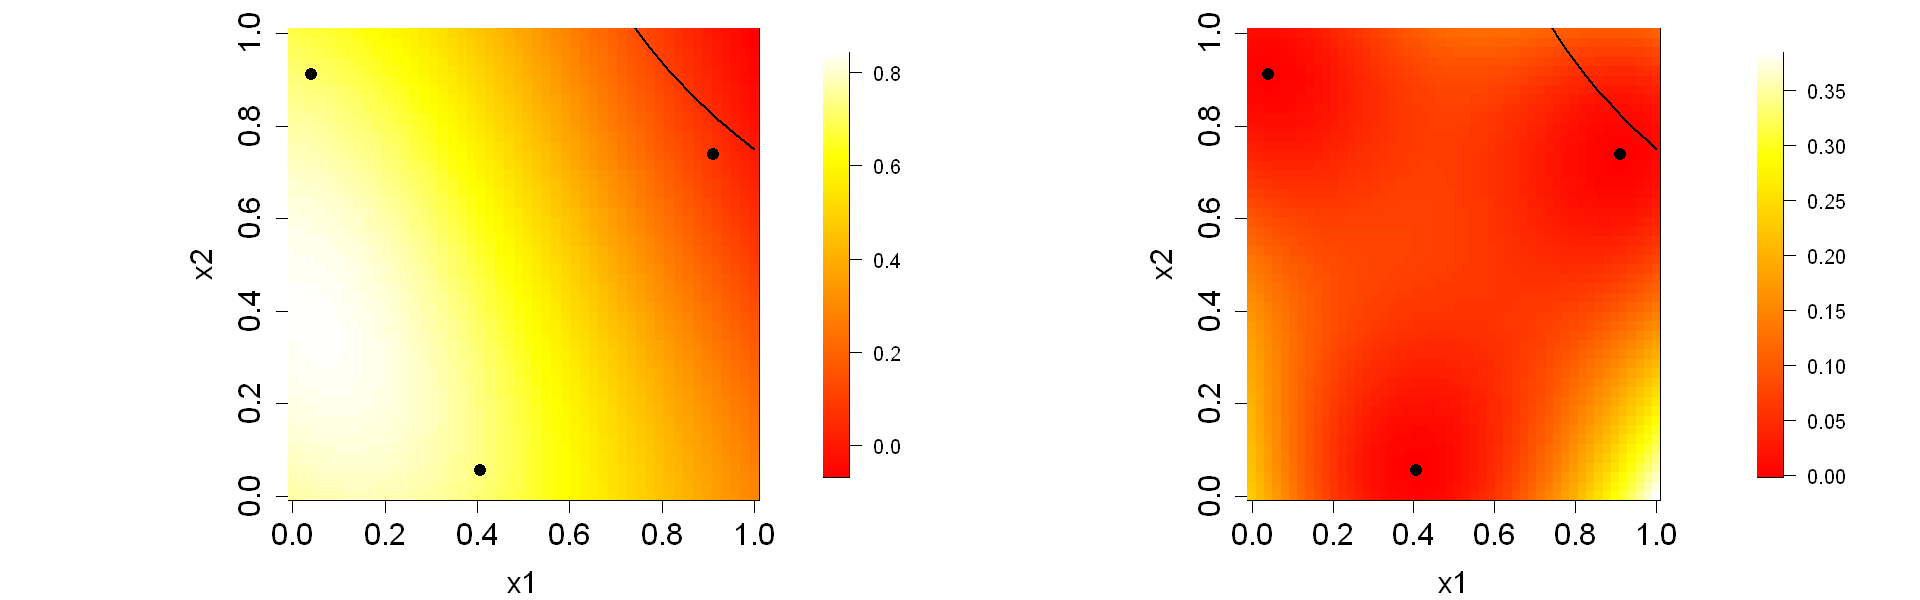

In [3]:
# Sample evenly in the entire input space and calculate the fitted Kriging results
level <- seq(0, 1, length=50)
X_ALL <- expand.grid(level,level)
DX_ALL <- distance(X_ALL)
SX_ALL <- exp(-DX_ALL) + diag(eps, ncol(DX_ALL))
D_ALL <- distance(X_ALL, x)
S_ALL <- exp(-D_ALL)
# Insert into the linear predictor
mup_ALL <- S_ALL %*% Si %*% y
Sigma_ALL <- SX_ALL - S_ALL %*% Si %*% t(S_ALL)
DIAG_ALL <- diag(Sigma_ALL)
cols <- heat.colors(128)
options(repr.plot.width=16, repr.plot.height=5)
par(mfrow=c(1,2))
par(mar=c(5.5,5,1.6,3))
image.plot(level,level, matrix(mup_ALL,ncol=50), xlab="x1", ylab="x2", col=cols,cex.lab=1.5,cex.axis=1.5)
points(x$X1[1:n_init],x$X2[1:n_init],pch=20,cex=2)
lines(level,0.75/level,lwd=2)
par(mar=c(5.5,5,1.6,4.5))
image.plot(level,level, matrix(DIAG_ALL,ncol=50), xlab="x1", ylab="x2", col=cols,cex.lab=1.5,cex.axis=1.5)
points(x$X1[1:n_init],x$X2[1:n_init],pch=20,cex=2)
lines(level,0.75/level,lwd=2)

We see that only 3 points can fit a similar pattern compared with the true response. The region around the sample points have a less standard error.

The next step is to take a new sample from the 97 samples not used. The intuitive choice is that this sample can improve the model the best if it is from a unsampled region with a large uncertainty. However, our focus for the reliability problem is to find the failure region, and sometimes the best estimates tell us that it is very likely that the unsampled region is not a failure region. Therefore the adaptive sampling approach we use (based on Echard et al, 2011) considers both features to select a new sample: (1) how large is the variance (or how far is it from the known samples); (2) how close is its best estimate to zero (or how likely is it near the boundary between success and failure). 

This is done by a rather simple learning function: U(x)=abs(mean)/std
To understand it simply, imagine a normal distribution: if its standard deviation is close to its mean, then the point zero will be closer to the center of the distribution; if the standard deviation is much smaller than the mean, then zero is at the tail of the distribution. Hence if U(x) is small, it means the uncertainty range covers zero with a larger probability so the point is more likely to be around the boundary.

The criterion here is U(x)=2, because for a normal distribution, 2sigma is at the 0.977 quantile. This means if U(x)=2, the 95% confidence interval does not include zero.

We calculate U(x) for all the rest 97 samples, and pick the sample with the least U(x). We add this sample with previous 3 samples to fit a new Kriging model. We repeat this process until the least U(x) among the remaining samples is larger than 2. 

Another stopping criterion is coefficient of variation (COV), which quantifies the uncertainty of probability of failure. A small probability of failure means we need a larger total sample size to make sure we are sampling the small probability correctly. This is also the reason we choose 15000 as the total sample size here.

In [4]:
# Adaptive learning part:
# Now we build the Kriging model, the next step is to add an additional point that minimize the
#   learning function U(x)
U <- abs(mup)/diag(Sigmap)
P_fail <- (sum(mup<0)+sum(y<0))/N
COV <- sqrt((1-P_fail)/(P_fail*N))
while ((min(abs(U))<=2) | (COV>0.05)){
  n <- n+1
  i <- which(U==min(U))
  x <- rbind.data.frame(x,X[i, ])
  y <- Reliability(x)
  d <- distance(x)
  Sigma <- exp(-d) + diag(eps, nrow(x))
  # Update remaining samples
  X <- X[-i, ]
  DX <- distance(X)
  SX <- exp(-DX) + diag(eps, ncol(DX))
  # Update distances matrices
  D <- distance(X, x)
  S <- exp(-D)
  Si <- solve(Sigma)
  mup <- S %*% Si %*% y
  Sigmap <- SX - S %*% Si %*% t(S)
  Diag <- diag(Sigmap)
  U <- abs(mup)/diag(Sigmap)
  P_fail <- (sum(mup<0)+sum(y<0))/N
  COV <- sqrt((1-P_fail)/(P_fail*N))
  print(c(n,min(U),COV))
}

[1] 4.000000000 0.009203165 0.044015240
[1] 5.0000000 0.7620624 0.0444314
[1] 6.00000000 2.52038261 0.04447834


We plot the current Kriging model as well as current samples again:

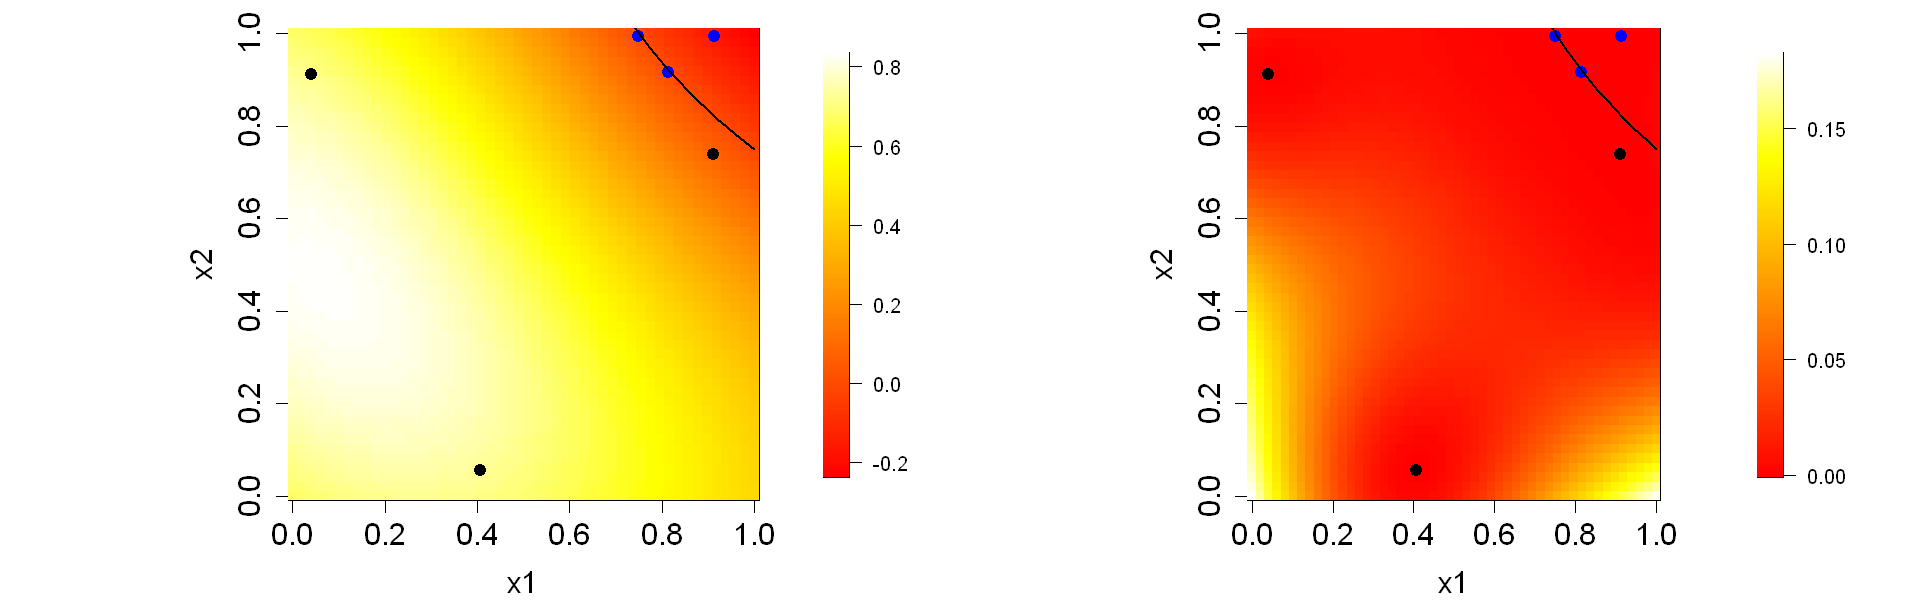

In [5]:
# Sample evenly in the entire input space and calculate the fitted Kriging results
level <- seq(0, 1, length=50)
X_ALL <- expand.grid(level,level)
DX_ALL <- distance(X_ALL)
SX_ALL <- exp(-DX_ALL) + diag(eps, ncol(DX_ALL))
D_ALL <- distance(X_ALL, x)
S_ALL <- exp(-D_ALL)
# Insert into the linear predictor
mup_ALL <- S_ALL %*% Si %*% y
Sigma_ALL <- SX_ALL - S_ALL %*% Si %*% t(S_ALL)
DIAG_ALL <- diag(Sigma_ALL)
cols <- heat.colors(128)
options(repr.plot.width=16, repr.plot.height=5)
par(mfrow=c(1,2))
par(mar=c(5.5,5,1.6,3))
image.plot(level,level, matrix(mup_ALL,ncol=50), xlab="x1", ylab="x2", col=cols,cex.lab=1.5,cex.axis=1.5)
points(x$X1[1:n_init],x$X2[1:n_init],pch=20,cex=2)
points(x$X1[(n_init+1):n],x$X2[(n_init+1):n],pch=20,cex=2,col="blue")
lines(level,0.75/level,lwd=2)
par(mar=c(5.5,5,1.6,4.5))
image.plot(level,level, matrix(DIAG_ALL,ncol=50), xlab="x1", ylab="x2", col=cols,cex.lab=1.5,cex.axis=1.5)
points(x$X1[1:n_init],x$X2[1:n_init],pch=20,cex=2)
points(x$X1[(n_init+1):n],x$X2[(n_init+1):n],pch=20,cex=2,col="blue")
lines(level,0.75/level,lwd=2)

We see the 3 new samples are all locating near the boundary line. Now we can treat this emulator as accurate enough. Though we still see some relative high variance regions in the below, because it is extreme unlikely to be a failure region, we do not need to make further sample there. Note we only take 6 samples in total. We now try to repeat the entire process with a higher standard for the learning function: U(x) must be larger than 10. 

[1] 4.000000000 0.001810977 0.041044449
[1] 5.000000000 0.006706021 0.044015240
[1] 6.00000000 0.13649064 0.04410675
[1] 7.00000000 1.41378330 0.04438461
[1] 8.00000000 2.41110046 0.04452543
[1]  9.00000000 14.25213137  0.04476301


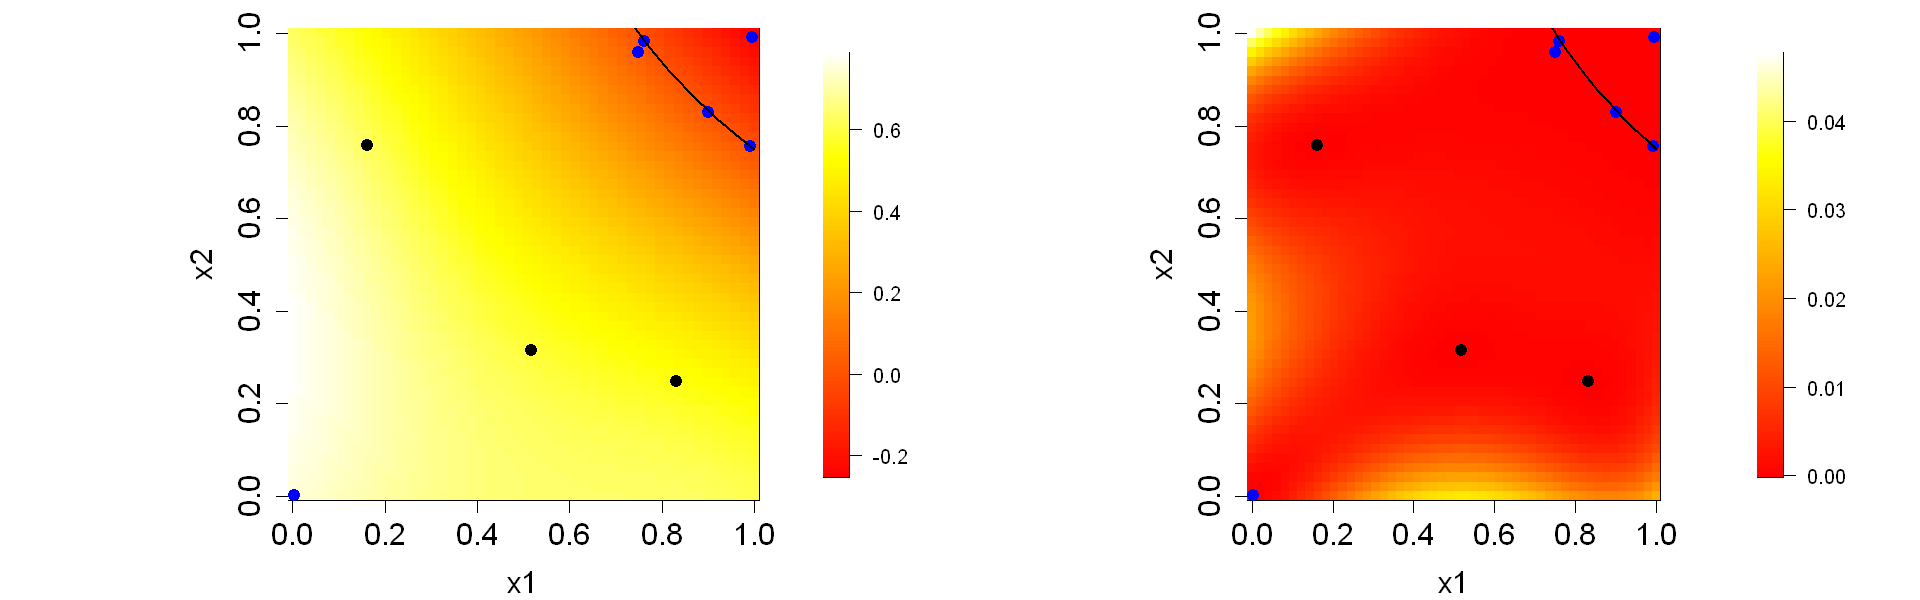

In [6]:
N <- 15000
n <- 3
n_init <- n
X_all <- data.frame(randomLHS(N,2))
# x is the samples we use, X is the rest samples
x <- X_all[c(1:n), ]
X <- X_all[c((n+1):N), ]
y <- Reliability(x)
d <- distance(x)
Sigma <- exp(-d) + diag(eps, nrow(x))
DX <- distance(X)
SX <- exp(-DX) + diag(eps, ncol(DX))
D <- distance(X, x)
S <- exp(-D)
# Insert into the linear predictor
Si <- solve(Sigma)
mup <- S %*% Si %*% y
Sigmap <- SX - S %*% Si %*% t(S)
U <- abs(mup)/diag(Sigmap)
P_fail <- (sum(mup<0)+sum(y<0))/N
COV <- sqrt((1-P_fail)/(P_fail*N))
while ((min(abs(U))<=10) | (COV>0.05)){
  n <- n+1
  i <- which(U==min(U))
  x <- rbind.data.frame(x,X[i, ])
  y <- Reliability(x)
  d <- distance(x)
  Sigma <- exp(-d) + diag(eps, nrow(x))
  # Update remaining samples
  X <- X[-i, ]
  DX <- distance(X)
  SX <- exp(-DX) + diag(eps, ncol(DX))
  # Update distances matrices
  D <- distance(X, x)
  S <- exp(-D)
  Si <- solve(Sigma)
  mup <- S %*% Si %*% y
  Sigmap <- SX - S %*% Si %*% t(S)
  Diag <- diag(Sigmap)
  U <- abs(mup)/diag(Sigmap)
  P_fail <- (sum(mup<0)+sum(y<0))/N
  COV <- sqrt((1-P_fail)/(P_fail*N))
  print(c(n,min(U),COV))
}
level <- seq(0, 1, length=50)
X_ALL <- expand.grid(level,level)
DX_ALL <- distance(X_ALL)
SX_ALL <- exp(-DX_ALL) + diag(eps, ncol(DX_ALL))
D_ALL <- distance(X_ALL, x)
S_ALL <- exp(-D_ALL)
# Insert into the linear predictor
mup_ALL <- S_ALL %*% Si %*% y
Sigma_ALL <- SX_ALL - S_ALL %*% Si %*% t(S_ALL)
DIAG_ALL <- diag(Sigma_ALL)
cols <- heat.colors(128)
options(repr.plot.width=16, repr.plot.height=5)
par(mfrow=c(1,2))
par(mar=c(5.5,5,1.6,3))
image.plot(level,level, matrix(mup_ALL,ncol=50), xlab="x1", ylab="x2", col=cols,cex.lab=1.5,cex.axis=1.5)
points(x$X1[1:n_init],x$X2[1:n_init],pch=20,cex=2)
points(x$X1[(n_init+1):n],x$X2[(n_init+1):n],pch=20,cex=2,col="blue")
lines(level,0.75/level,lwd=2)
par(mar=c(5.5,5,1.6,4.5))
image.plot(level,level, matrix(DIAG_ALL,ncol=50), xlab="x1", ylab="x2", col=cols,cex.lab=1.5,cex.axis=1.5)
points(x$X1[1:n_init],x$X2[1:n_init],pch=20,cex=2)
points(x$X1[(n_init+1):n],x$X2[(n_init+1):n],pch=20,cex=2,col="blue")
lines(level,0.75/level,lwd=2)

Just 9 sample points are enough. All the additional samples are near the boundary except one at the corner.

We can see the power of AKMCS method, it only needs to calculate very few samples to create an accurate enough emulator for reliability problems. Part of the reason of using this few samples is because our example is too simple and regular here. We can test more complex functions later. 

In a sensitivity analysis example, we can now perform a Sobol analysis using  millions of new samples from the surrogate model with very little computation costs (imagine the original problem is complex).

AKMCS is a powerful emulation tool to save computational costs for complex models.